References: 

- [Galenko, A., Popova, E., and Popova, I. (2012). **Trading in the presence of cointegration.** *The Journal of Alternative Investments*, 15(1):85–97.](http://www.ntuzov.com/Nik_Site/Niks_files/Research/papers/stat_arb/Galenko_2007.pdf)


# Multivariate Cointegration Framework

## Introduction

The cointegration relations between time series imply that the time series are bound together. Over time the time series
might drift apart for a short period of time, but they ought to re-converge. A trading strategy on $N \: (N \geq 3)$ cointegrated assets that have a positive expectation of profit can be designed based on this property. 

In this notebook, the trading strategy will be demonstrated, and an empirical example of applying this strategy to four European stock indices will be given.

## Multivariate Cointegration

Cointegration is defined by the stochastic relationships among the asset log returns.

Let $P_i$, where $i = 1, 2, \ldots, N$ denote the price of $N$ assets. The continuously compounded asset
returns, i.e. log-returns at time $t > 0$ can be written as:

\begin{equation*}
r_t^i = \ln{P_t^i} - \ln{P_{t-1}^i}
\end{equation*}

Now construct a process $Y_t$ as a linear combination of the $N$ asset prices:

\begin{equation*}
Y_t = \sum_{i=1}^N b^i \ln{P_t^i}
\end{equation*}

where $b^i$ denotes the $i$-th element for a finite vector $\mathbf{b}$.

The corresponding asset returns series $Z_t$ can be defined as:

\begin{equation*}
Z_t = Y_t - Y_{t-1} = \sum_{i=1}^N b^i r_t^i
\end{equation*}

Assume that the memory of the process $Y_t$ does not extend into the infinite past, which can be expressed as the
following expression in terms of the autocovariance of the process $Y_t$:

\begin{equation*}
\lim_{p \to \infty} \text{Cov} \lbrack Y_t, Y_{t-p} \rbrack = 0
\end{equation*} 

Then the **log-price** process $Y_t$ is stationary, if and only if the following three conditions on
**log-returns** process $Z_t$ are satisfied:

\begin{gather*}
E[Z_t] = 0 \\
\text{Var }Z_t = -2 \sum_{p=1}^{\infty} \text{Cov} \lbrack Z_t, Z_{t-p} \rbrack \\
\sum_{p=1}^{\infty} p \text{ Cov} \lbrack Z_t, Z_{t-p} \rbrack < \infty
\end{gather*}

When $Y_t$ is stationary, the log-price series of the assets are cointegrated.

For equity markets, the log-returns time series can be assumed as stationary and thus satisfy the above conditions.
Therefore, when it comes to empirical applications, the Johansen test could be directly applied to the log price series
to derive the vector $\mathbf{b}$.

## Trading Strategy

The core idea of the strategy is to bet on the spread formed by the cointegrated $N$ assets that have gone apart
but are expected to mean revert in the future.

The trading strategy, using the notation in the above section, can be described as follows.

1. Estimate the cointegration vector $\hat{\mathbf{b}}$ with Johansen test using training data.
2. Construct the realization $\hat{Y}_t$ of the process $Y_t$ by calculating $\hat{\mathbf{b}}^T \ln P_t$, and calculate $\hat{Z}_t = \hat{Y}_t - \hat{Y}_{t-1}$.
3. Compute the finite sum $\sum_{p=1}^P \hat{Z}_{t-p}$, where the lag $P$ is an input argument.
4. Partition the assets into two sets $L$ and $S$ according to the sign of the element in the cointegration vector $\hat{\mathbf{b}}$. For each asset $i$,

\begin{eqnarray*}
i \in L \iff b^i \geq 0 \\
i \in S \iff b^i < 0
\end{eqnarray*}

5. Following the formulae below, calculate the number of assets to trade so that the notional of the positions would equal to $C$.

\begin{eqnarray*}
    \Bigg \lfloor \frac{-b^i C \text{ sgn} \bigg( \sum_{p=1}^{P} Z_{t-p} \bigg)}{P_t^i \sum_{j \in L} b^j} \Bigg \rfloor, \: i \in L \\
    \Bigg \lfloor \frac{b^i C \text{ sgn} \bigg( \sum_{p=1}^{P} Z_{t-p} \bigg)}{P_t^i \sum_{j \in L} b^j} \Bigg \rfloor, \: i \in S
\end{eqnarray*}

6. Open the positions on time $t$ and close the positions on time $t+1$.
7. Update the training data with the closing price.
8. The cointegration vector will be re-estimated monthly (22 trading days). If it is time for a re-estimate, go to step 1; otherwise, go to step 2.

The strategy is trading at daily frequency and always in the market.

## Usage of the Module

In this section, the usage of multivariate cointegration trading strategy will be demonstrated with an empirical example of four European stock indices, i.e. DAX (Germany), CAC 40 (France), FTSE 100 (UK), and AEX (Netherlands). Price history from Jan 2nd, 1996 to Dec 28th, 2006 were used. The module allows two missing data imputation methods: forward-fill and polynomial spline. In the following demonstration, missing data due to difference in working days in different countries was imputed with forward-fill method in order to avoid introduction of phantom returns on non-trading days.

Trading for out-of-sample tests starts on Nov 6th, 2001 and ends on Dec 28th, 2006. The cointegration vector $\mathbf{b}$ was re-estimated monthly (every 22 trading days) using Johansen test. The notional value of the long positions and short positions each day was set to $\$10 \text{M}$, respectively. To be specific, each day $\$10 \text{M}$ were invested in longs and another $\$10 \text{M}$ were invested in shorts, resulting in a $\$20 \text{M}$ portfolio.

In [1]:
%matplotlib inline

In [2]:
# Import libraries
from arbitragelab.cointegration_approach.multi_coint import MultivariateCointegration

import pandas as pd
import numpy as np

In [3]:
# Load data
euro_stocks_df = pd.read_csv("tests/test_data/multi_coint.csv", parse_dates=['Date'])
euro_stocks_df.set_index("Date", inplace=True)

# Out-of-sample data split time point
split_point = pd.Timestamp(2001, 11, 6)

# Indexing with DateTimeIndex is always inclusive. Remove the last data point in the training data
train_df = euro_stocks_df.loc[:split_point].iloc[:-1]
trade_df = euro_stocks_df.loc[split_point:]

In [4]:
# Check train data
train_df.tail()

,AEX,DAX,FTSE,CAC
Date,,,,
2001-10-30,452.63,4543.98,5003.60,4251.93
2001-10-31,460.33,4559.13,5039.71,4341.29
2001-11-01,464.99,4636.13,5071.23,4366.94
2001-11-02,468.15,4583.31,5129.54,4369.40
2001-11-05,482.97,4755.11,5209.12,4485.34


In [5]:
# Check test data
trade_df.head()

,AEX,DAX,FTSE,CAC
Date,,,,
2001-11-06,482.17,4707.65,5214.06,4461.69
2001-11-07,490.19,4860.66,5216.27,4493.27
2001-11-08,500.14,4993.57,5278.09,4573.04
2001-11-09,488.86,4910.07,5244.21,4514.28
2001-11-12,476.29,4820.37,5146.23,4376.58


### Generate Trading Signal and Equity Curve

In this section, a few experiments will be done to showcase the following:

- In-sample test of the strategy with a rolling window.
- In-sample test of the strategy with a cumulative window.
- Out-of-sample test of the strategy with a rolling window.
- Out-of-sample test of the strategy with a cumulative window.

A lag of 30 days will be used across four experiments to calculate the signals.

For in-sample test, the cointegration vector will be estimated with all available data (including training and test data) and will not be updated monthly. 

The equity curve and the statistics of the returns are shown for each experiment.

In [6]:
# Initialize the trading signal generator
multi_coint_signal = MultivariateCointegration(train_df, trade_df)

### 1) In-sample, rolling window of 1500 days

In [7]:
# Generating the signal, recording the cointegration vector time evolution and calculate portfolio returns
signal, coint_vec, port_returns = multi_coint_signal.trading_signal(nlags=30, rolling_window_size=1500, insample=True)

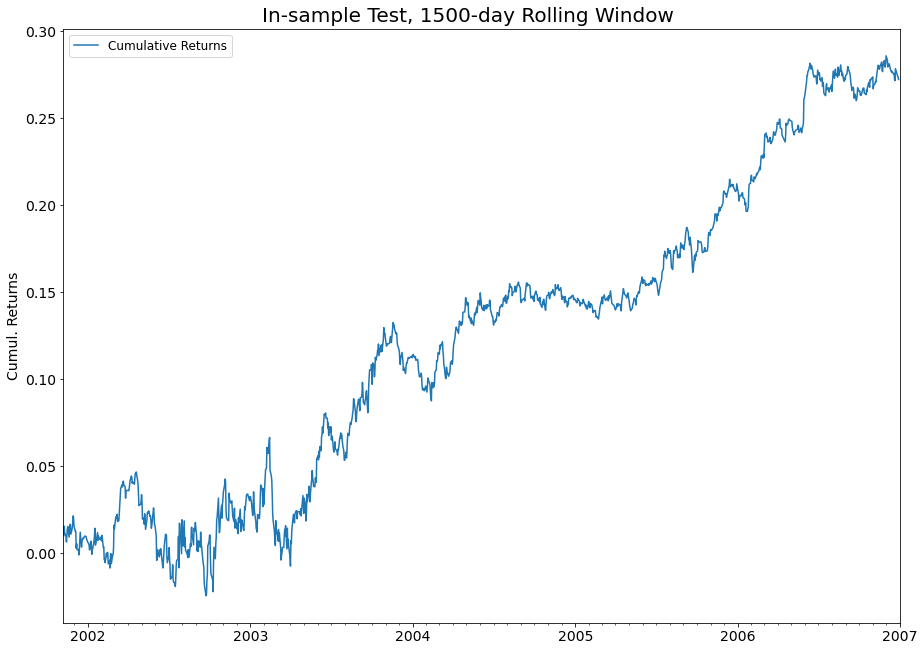

In [8]:
# Plot the equity curve
plot = multi_coint_signal.plot_returns(port_returns, start_date=pd.Timestamp(2001, 11, 6), end_date=pd.Timestamp(2007, 1, 2),
                                       figw=15, figh=10, title="In-sample Test, 1500-day Rolling Window")

In [9]:
# Return statistics
multi_coint_signal.summary(port_returns)

,0
Cumulative Return,0.272364
Returns Mean,0.000189
Returns Standard Deviation,0.003861
Returns Skewness,0.332307
Returns Kurtosis,4.586762
Max Return,0.025797
Min Return,-0.017856
Sharpe ratio,0.777633
Sortino ratio,1.137467
Percentage of Up Days,0.508296


### 2) In-sample, cumulative window

In [10]:
# Generating the signal, recording the cointegration vector time evolution and calculate portfolio returns
signal, coint_vec, port_returns = multi_coint_signal.trading_signal(nlags=30, rolling_window_size=None, insample=True)

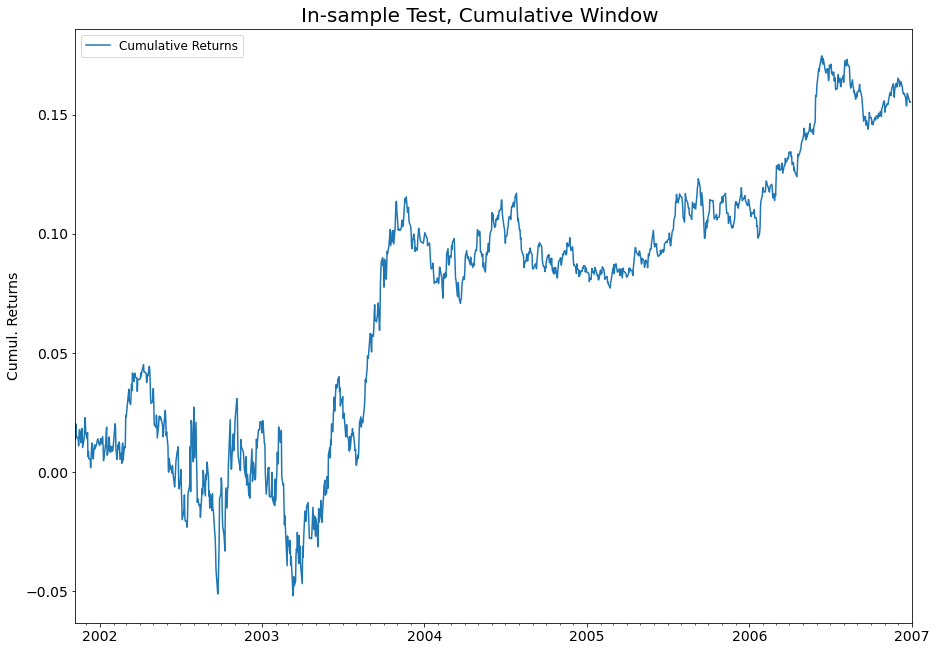

In [11]:
# Plot the equity curve
plot = multi_coint_signal.plot_returns(port_returns, start_date=pd.Timestamp(2001, 11, 6), end_date=pd.Timestamp(2007, 1, 2),
                                       figw=15, figh=10, title="In-sample Test, Cumulative Window")

In [12]:
# Returns Statistics
multi_coint_signal.summary(port_returns)

,0
Cumulative Return,0.155303
Returns Mean,0.000117
Returns Standard Deviation,0.004130
Returns Skewness,0.399335
Returns Kurtosis,5.443765
Max Return,0.030058
Min Return,-0.019316
Sharpe ratio,0.451185
Sortino ratio,0.644448
Percentage of Up Days,0.513575


### 3) Out-of-sample, rolling window of 1500 days

In [13]:
# Generating the signal, recording the cointegration vector time evolution and calculate portfolio returns
signal, coint_vec, port_returns = multi_coint_signal.trading_signal(nlags=30, rolling_window_size=1500, insample=False)

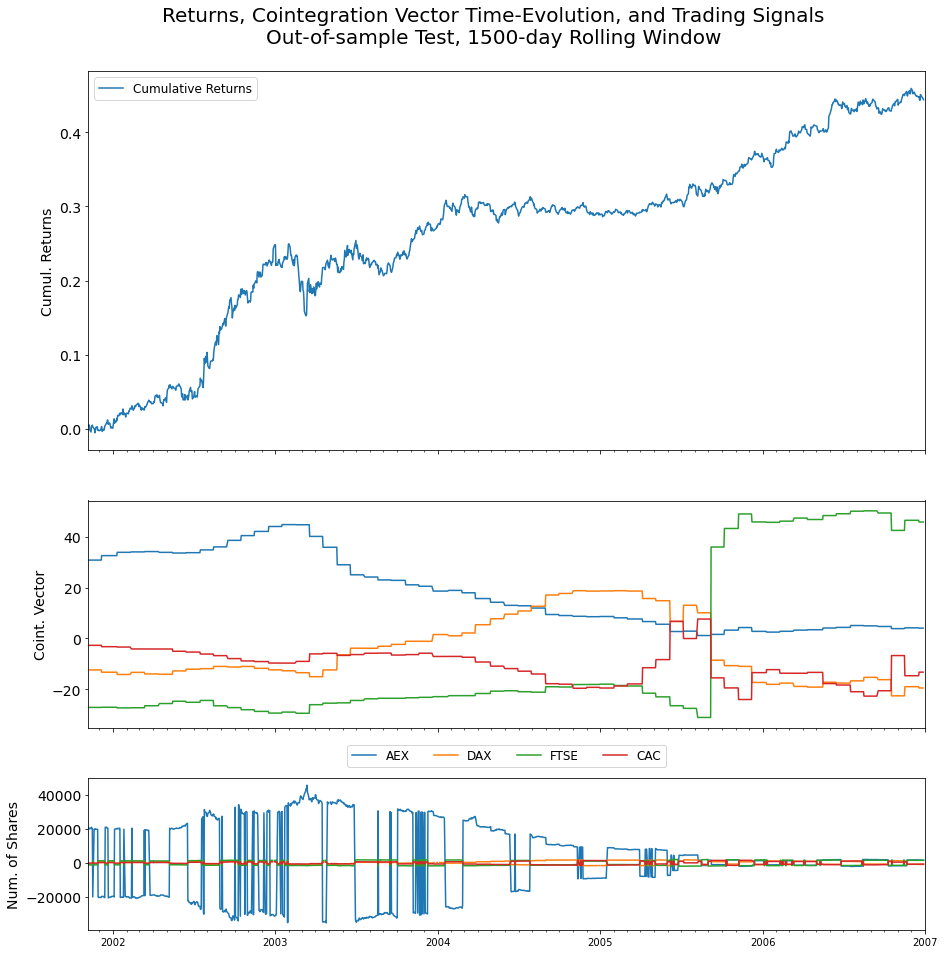

In [14]:
# Plot the equity curve, cointegration vectors, and trading signals
plot = multi_coint_signal.plot_all(signal, coint_vec, port_returns,
                                   start_date=pd.Timestamp(2001, 11, 6), end_date=pd.Timestamp(2007, 1, 2),
                                   title="Out-of-sample Test, 1500-day Rolling Window")

In [15]:
# Returns statistics
multi_coint_signal.summary(port_returns)

,0
Cumulative Return,0.444103
Returns Mean,0.000283
Returns Standard Deviation,0.003392
Returns Skewness,-0.068326
Returns Kurtosis,5.615824
Max Return,0.018280
Min Return,-0.022511
Sharpe ratio,1.324196
Sortino ratio,1.826150
Percentage of Up Days,0.539970


### 4) Out-of-sample, cumulative window

In [16]:
# Generating the signal, recording the cointegration vector time evolution and calculate portfolio returns
signal, coint_vec, port_returns = multi_coint_signal.trading_signal(nlags=30, rolling_window_size=None, insample=False)

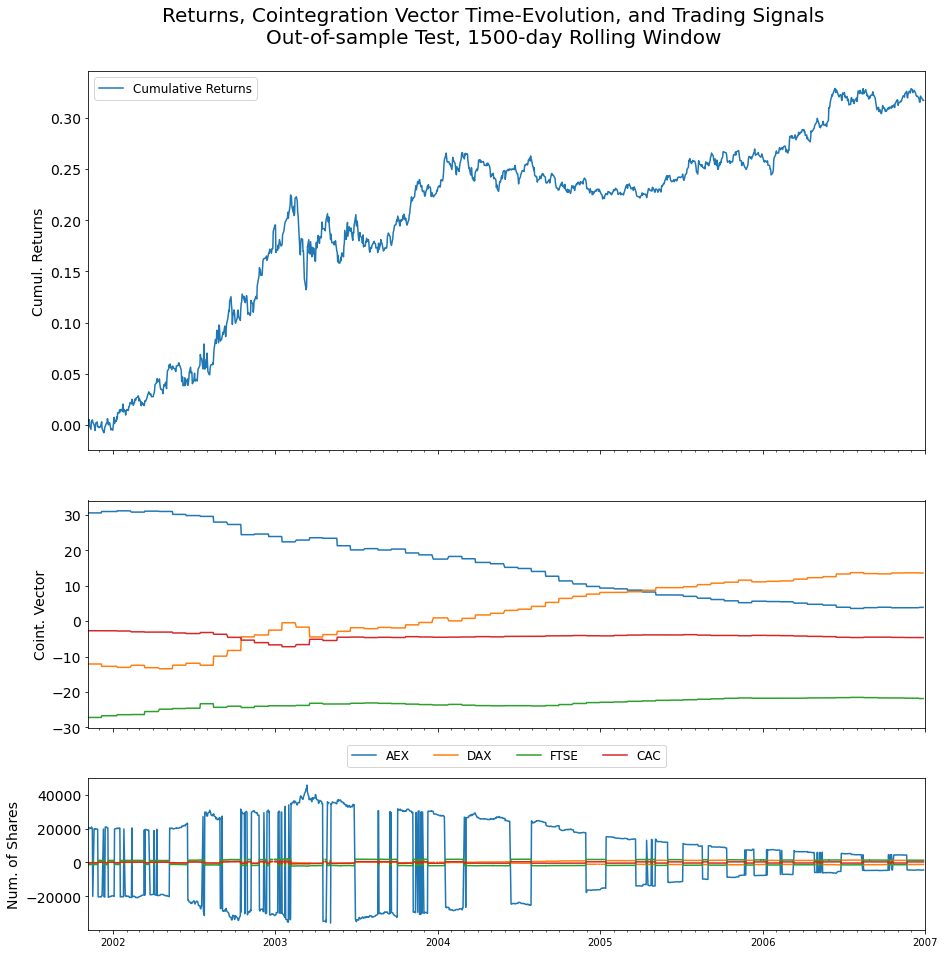

In [17]:
# Plot the equity curve, cointegration vectors, and trading signals
plot = multi_coint_signal.plot_all(signal, coint_vec, port_returns,
                                   start_date=pd.Timestamp(2001, 11, 6), end_date=pd.Timestamp(2007, 1, 2),
                                   title="Out-of-sample Test, 1500-day Rolling Window")

In [18]:
# Returns Statistics
multi_coint_signal.summary(port_returns)

,0
Cumulative Return,0.317315
Returns Mean,0.000214
Returns Standard Deviation,0.003540
Returns Skewness,-0.177860
Returns Kurtosis,5.428452
Max Return,0.019058
Min Return,-0.022511
Sharpe ratio,0.960292
Sortino ratio,1.301625
Percentage of Up Days,0.529412
